In [1]:
import cv2
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model

from sklearn.model_selection import train_test_split

SIZE_FACE = 48
EMOTIONS = ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
np.random.seed(42)


Using TensorFlow backend.


In [2]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

model = load_model('./data/keras_model.h5')
model_original = load_model('./data/keras_model.h5')

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_16')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 18, 18, 64)        102464    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 6, 6, 128)         131200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4608)              0         
__________

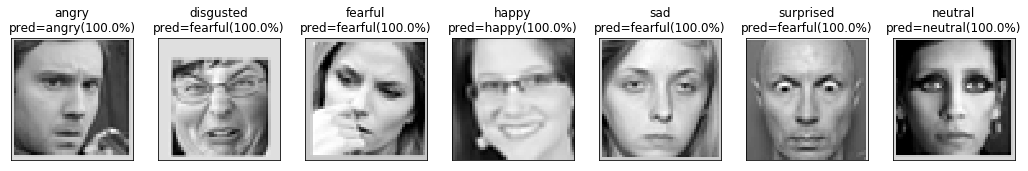

In [3]:
from vis.utils import utils
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

img= []
for i in range(len(EMOTIONS)):
    img.append(cv2.imread(r'./data/image' +str(i)+ '.png', 0))


f, ax = plt.subplots(1, len(img))
for i in range(len(img)):
    ax[i].imshow(img[i], cmap='gray')
    plt.setp(ax, xticks=[], yticks=[])
    img[i] = img[i].reshape(-1, 48, 48,1)
    prediction = model_original.predict(img[i])
    index = prediction.argmax()
    ax[i].set_title( EMOTIONS[i] + '\npred=' + EMOTIONS[index] + '(' + str(prediction[0][index]*100) + '%)')


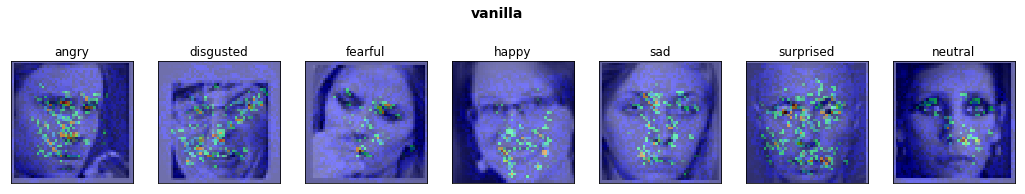

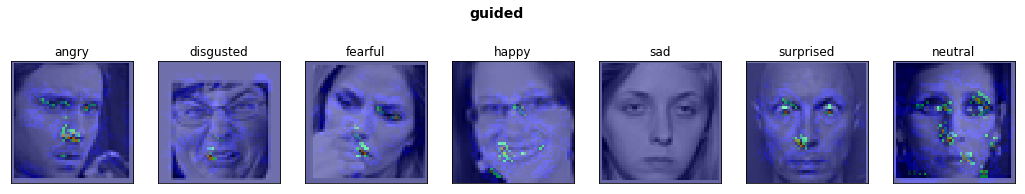

In [4]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations
import matplotlib.cm as cm

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'dense_16')

for modifier in [None, 'guided']:
    f, ax = plt.subplots(1, len(img))
    f.subplots_adjust(top=1.3)
    plt.suptitle("vanilla" if modifier is None else modifier, fontsize=14, fontweight='bold')
    plt.setp(ax, xticks=[], yticks=[])
    for i, img_ in enumerate(img):    
        grads = visualize_saliency(model, layer_idx, filter_indices=i, 
                                   seed_input=img_, backprop_modifier=modifier)
        jet_heatmap = np.uint8(cm.jet(grads)[..., :3,0] * 255)
        ax[i].set_title(EMOTIONS[i])
        ax[i].imshow(overlay(jet_heatmap, cv2.cvtColor(img_.reshape(48,48),cv2.COLOR_GRAY2RGB)))
        
plt.show()

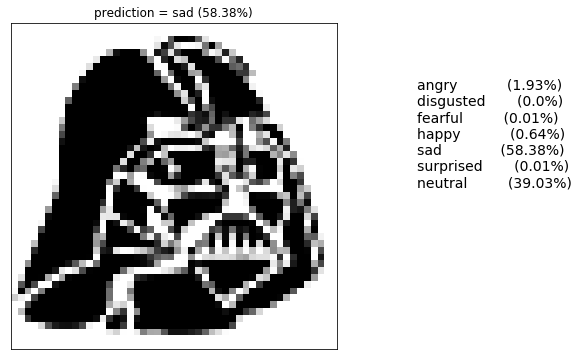

In [5]:
plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

img_vader = cv2.imread(r'./data/imageVader.png', 0)
img_vader = cv2.resize(img_vader, (SIZE_FACE, SIZE_FACE), interpolation = cv2.INTER_CUBIC) / 255.0

f, ax = plt.subplots(1, 1)

ax.imshow(img_vader,cmap='gray')
plt.setp(ax, xticks=[], yticks=[])

img_vader = img_vader.reshape(-1, 48, 48,1)
prediction = model_original.predict(img_vader)

index = prediction.argmax()
ax.set_title('prediction = ' + EMOTIONS[index] + ' (' + str(np.around(prediction[0][index]*100,2)) + '%)')

textstr = str()
for i in range(len(EMOTIONS)):
    textstr = textstr + '\n' + EMOTIONS[i] + '\t\t(' + str(np.around(prediction[0][i]*100,2)) + '%)'
    if i == 1 or i == 5:
        textstr = textstr[:textstr.rfind('\t')] + textstr[textstr.rfind('\t')+1:] 

textstr = textstr.expandtabs()

plt.gcf().text(0.7, 0.5, textstr, fontsize=14)

plt.show()